# Multivatiate Bitcoin time series forecasting

In this notebook we will focus on different models that can be use to forecast multivatiare time series. We will take a closer look on multivariate linear dynamical system and later we will try to build model based on Kalman kernel.
Let start with importing packages and preparing the data.

## Initial numpyro and pyro installation

In [69]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Needed imports


In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time
from datetime import timedelta, date, datetime
from copy import deepcopy

import torch

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.ops.stats import quantile


# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# For this approach we decided to analyze how different cryptocurrencies and USD dollar value impact Bitcoin price, so we will build model for multivariate time series forecasting

## Bitcoin data

### Read file with Bitcoin pricees in USD

In [72]:
df_price = pd.read_csv('/content/drive/MyDrive/model-based/BTC-USD.csv', parse_dates=True)

### See sample data in table

In [73]:
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


### For the purpose of the project we will focus only on the Bitcoin prices and other data that may have an impact on price, we won't be analyzing the different features of bitcoin, so we will remove columns we don't use

In [74]:
df_price = df_price.drop(columns = ["Open", "High", "Low", "Close", "Volume"])

### Visualize the BTC price in time

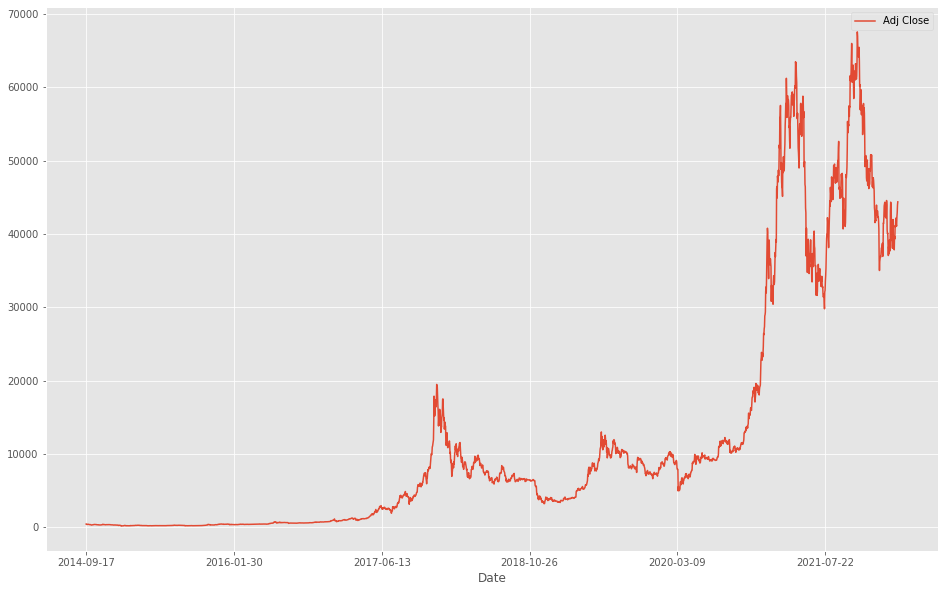

In [75]:
df_price.plot(x="Date", y="Adj Close")
plt.show()

We see that the process is not regular and have big fluctuations. We will try to determine if other cryptocurrencies and price of USD dollar are correlated with bitcoin prices and how the impact the price predictions.

## USD index data - we choose this data because it is described as independed measure od USD based on 6 other stable currencies. That way we get the value of USD witouth any priors. 
### Load USD index data

In [76]:
df_usd = pd.read_csv('/content/drive/MyDrive/model-based/USD_historical_data.csv', parse_dates=True) 
print(df_usd.head(10))
# remove unnecessary columns
df_usd =df_usd.drop(columns=["Open", "High", "Low", "Vol.", "Change %"])
# print shape of both data frames
print(df_usd.shape)
print(df_price.shape)

           Date  Price   Open   High    Low Vol. Change %
0  Sep 17, 2014  84.34  84.10  84.78  83.94    -    0.32%
1  Sep 18, 2014  84.32  84.80  84.74  84.22    -   -0.02%
2  Sep 19, 2014  84.73  84.28  84.80  84.23    -    0.49%
3  Sep 22, 2014  84.75  84.78  84.86  84.52    -    0.02%
4  Sep 23, 2014  84.66  84.68  84.76  84.36    -   -0.11%
5  Sep 24, 2014  85.04  84.71  85.09  84.60    -    0.45%
6  Sep 25, 2014  85.19  85.10  85.48  85.05    -    0.18%
7  Sep 26, 2014  85.64  85.14  85.69  85.11    -    0.53%
8  Sep 29, 2014  85.59  85.62  85.80  85.46    -   -0.06%
9  Sep 30, 2014  85.94  85.61  86.22  85.49    -    0.41%
(1963, 2)
(2747, 2)


### As we see the shapes do not match, we notice that USD index data is missing entries for weekend days, we will fill this data with values from Friday.

In [77]:
N = df_usd.shape[0]
usd_list = df_usd.to_numpy() # change for numpy array

# add data for the weekend
usd_data =[]
for i in range(3, N, 5):
  if(i>=5):
    usd_data = np.vstack((usd_data, usd_list[i-5:i,:]))
  else: # first week
    usd_data = usd_list[0:i, :]
  # copy Friday data
  copy_friday =  deepcopy(usd_list[i-1,:])
  # change the day
  copy_friday[0] = datetime.strptime(copy_friday[0], "%b %d, %Y") + timedelta(days=1)
  # add data for Saturday
  usd_data = np.vstack((usd_data,copy_friday))
  # move one day
  copy_friday[0] = copy_friday[0] + timedelta(days=1)
  # add data for Sunday
  usd_data = np.vstack((usd_data,copy_friday))

# we are missing data for the last 5 dys
usd_data = np.vstack((usd_data,usd_list[-5:,:]))
# print length to check if it matches 
print(len(usd_data))

2747


### The result from filling missing data is a list, we work on pandas DataFrames so we will create dataframe out of it

In [78]:
df_usd_extended = pd.DataFrame(usd_data)
df_usd_extended.columns = ["Date_USD", "Price_USD"]
df_usd_extended = df_usd_extended["Price_USD"].astype(float)

## Other cryptocurrencies
We chose two of the oldest cryptocurrencies, that way we have a lot of data from which our model can learn.

### Load litecoin and ripple data

In [79]:
df_ltc = pd.read_csv('/content/drive/MyDrive/model-based/LTC-USD.csv', parse_dates=True) 
print(df_ltc.head(10))
# remove unnecessary columns
df_ltc =df_ltc.drop(columns=["Open", "High", "Low", "Close", "Volume"])
df_xrp = pd.read_csv('/content/drive/MyDrive/model-based/XRP-USD.csv', parse_dates=True) 
print(df_xrp.head(10))
# remove unnecessary columns
df_xrp =df_xrp.drop(columns=["Open", "High", "Low", "Close", "Volume"])

         Date     Open     High      Low    Close  Adj Close   Volume
0  2014-09-17  5.08589  5.17077  4.96595  5.05855    5.05855  3071840
1  2014-09-18  5.06543  5.06543  4.57996  4.68523    4.68523  4569260
2  2014-09-19  4.68729  4.75582  4.25435  4.32777    4.32777  3917450
3  2014-09-20  4.32920  4.61608  4.20219  4.28644    4.28644  5490660
4  2014-09-21  4.26307  4.30013  4.15499  4.24592    4.24592  2931220
5  2014-09-22  4.24593  4.41688  4.21013  4.24235    4.24235  1855960
6  2014-09-23  4.23999  4.88135  4.18887  4.74657    4.74657  4661670
7  2014-09-24  4.74420  4.74512  4.62769  4.66679    4.66679  2662290
8  2014-09-25  4.66588  4.67132  4.44870  4.51465    4.51465  2046960
9  2014-09-26  4.50993  4.55182  4.38880  4.43359    4.43359  1548350
         Date      Open      High       Low     Close  Adj Close      Volume
0  2017-11-09  0.217911  0.221791  0.214866  0.217488   0.217488   147916992
1  2017-11-10  0.218256  0.219068  0.205260  0.206483   0.206483   141032992

### Merge loaded data into one data frame

In [80]:
# merge data
df_merged = df_price.join(df_usd_extended)
df_merged = df_merged.join(df_ltc, rsuffix="_LTC")
# from previous output we see that ripple data begins later in time, so we need to clip other data
# remove data before 2017-11-09 - ripple data start
df_merged["Date"]= pd.to_datetime(df_merged['Date'])
ripple_date = pd.Timestamp(2017,11,9)
df_merged = df_merged[df_merged["Date"] >= ripple_date]
df_merged.reset_index(drop=True)
df_xrp["Date"]= pd.to_datetime(df_xrp['Date'])
df_xrp.set_index("Date")
df_merged = df_merged.merge(df_xrp, on="Date", how="inner", suffixes=("_BTC","_XRP"))
print(df_merged.shape)

(1598, 6)


### Visualization of gathered data

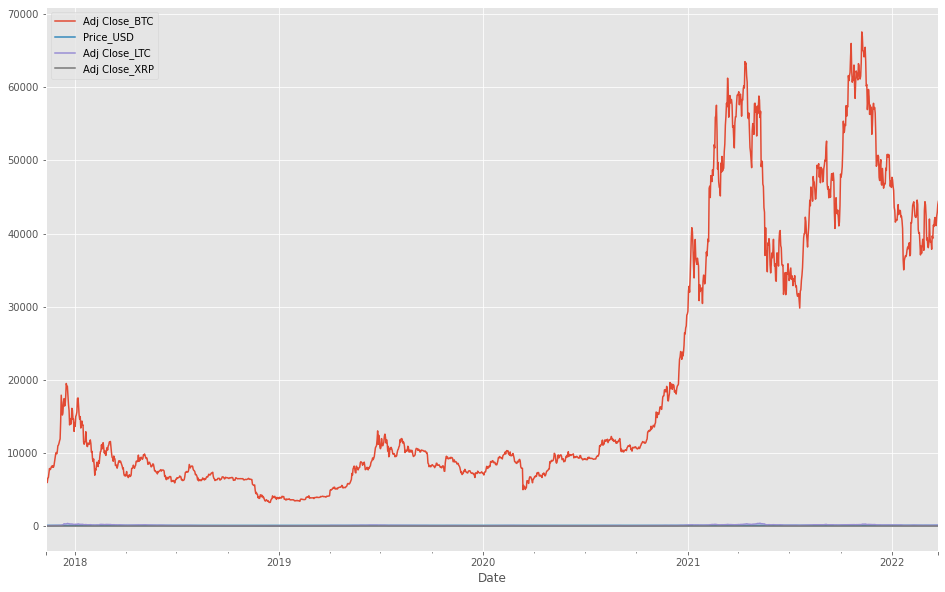

In [81]:
df_merged.plot(x="Date")

### As we see the prices for other cryptocurrencies and USD are much lower than Bitcoin price, to take a closer look on the process of them we print only these data

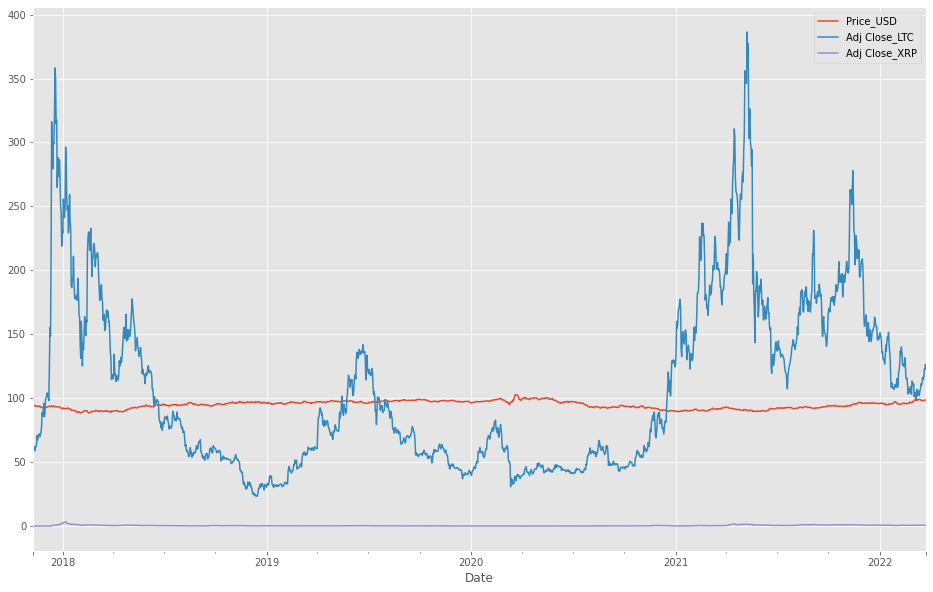

In [82]:
df_merged.plot(x="Date", y=["Price_USD", "Adj Close_LTC", "Adj Close_XRP"])

### Again we see that Ripple data is much lower, we print only this cryptocurrency

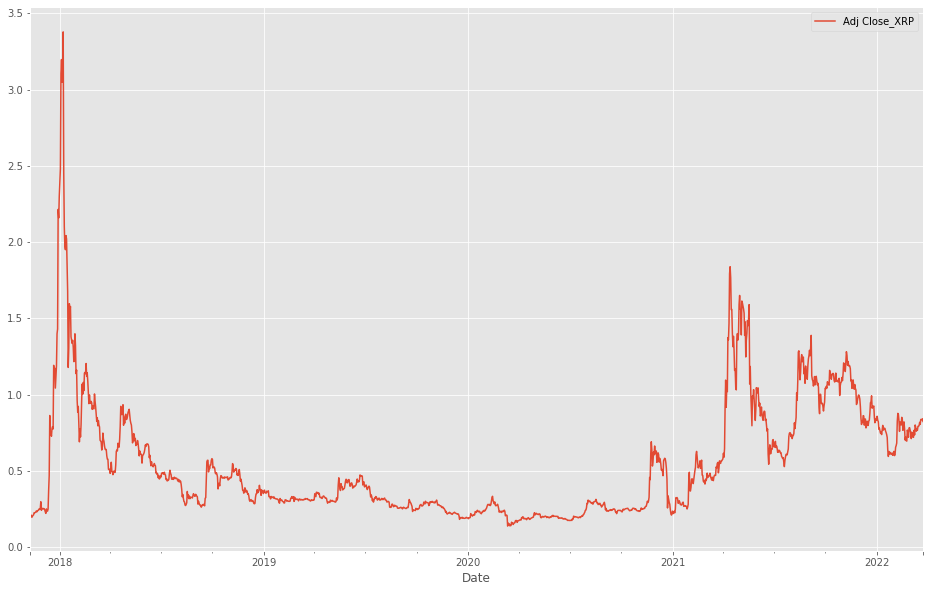

In [83]:
df_merged.plot(x="Date", y="Adj Close_XRP")

### As we see from the diagrams above, USD dollar has quite steady flow, where in other cases we observe big fluctuations. In order to understand the correlation between selected data we will print the correlation table

In [84]:
df_merged.corr()

,Adj Close_BTC,Price_USD,Adj Close_LTC,Adj Close_XRP
Adj Close_BTC,1.000000,-0.376877,0.717242,0.566144
Price_USD,-0.376877,1.000000,-0.605442,-0.488252
Adj Close_LTC,0.717242,-0.605442,1.000000,0.809344
Adj Close_XRP,0.566144,-0.488252,0.809344,1.000000


### We observe that Litecoin has the biggest dependency on Bitcoin, whereas USD dollar and Ripple have quite small correlation

# Prepare model

## We will introduce two approaches - multivariate linear dynamical system and model with Kalman kernel

## Firs we start with multivariate LDS model

### Prepare function to propagate dynamics

In [85]:
def f_y_with_noise(carry, noise):
  beta, y_prev= carry
  y_t = beta*y_prev  + noise
  y_prev = y_t
  return (beta, y_prev), y_t

### Models

### First model for forecasting based on latest batch of data

In [86]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast, N=3, obs_btc_price=None, obs_usd_price=None, obs_xrp=None, obs_ltc=None):
    # Define priors over beta, r, sigma, y_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(N), scale=jnp.ones(N)*3))
    r = numpyro.sample(name="r", fn=dist.HalfCauchy(scale=jnp.ones(N)*4))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1.5))
    y_prev = numpyro.sample(name="y_1", fn=dist.HalfCauchy(scale=jnp.ones(N)*5))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(N, 8.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(r)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(N), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, y_prev)
    y_collection = [y_prev]
    carry, ys_exp = lax.scan(f_y_with_noise, carry, noises, T+T_forecast-1)
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)
    

    # Sample the observed y (y_obs) - BTC 
    numpyro.sample(name="y_obs_btc", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_btc_price[:T])
    numpyro.sample(name="y_pred_btc", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
    # Sampe y - USD index
    numpyro.sample(name="y_obs_usd", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_usd_price[:T])
    numpyro.sample(name="y_pred_usd", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
    # Sampe y - xrp
    numpyro.sample(name="y_obs_xrp", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_xrp[:T])
    numpyro.sample(name="y_pred_xrp", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)

    return y_collection

While designing the model we started with default distributions for priors in most cases we used normal distribution. For 'y' variable we chose the HalfCauchy distribution, cause we know that the price values can be only positive. For this model we decided to base it only on bitcoin price, usd index value and ripple price, during development we observed that the litecoin price has a negatice impact on model, meaning the forcasted values are very close to 0. This may be the problem with high correlation between bitcoin price and litecoin price.

### Model for forecasting based on whole dataset

In [87]:
def model_full_data_load(T, T_forecast, N=4, obs_btc_price=None, obs_usd_price=None, obs_xrp=None, obs_ltc=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.LogNormal(loc=jnp.ones(N), scale=jnp.ones(N)*0.7))
    r = numpyro.sample(name="r", fn=dist.HalfCauchy(scale=jnp.ones(N)*1))
    sigma = numpyro.sample(name="sigma", fn=dist.Exponential(rate=1))
    y_prev = numpyro.sample(name="y_1", fn=dist.HalfCauchy(scale=jnp.ones(N)*15))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(N, 5.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(r)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(N), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, y_prev)
    y_collection = [y_prev]
    carry, ys_exp = lax.scan(f_y_with_noise, carry, noises, T+T_forecast-1)
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)
    

    # Sample the observed y (y_obs) - BTC 
    numpyro.sample(name="y_obs_btc", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_btc_price[:T])
    numpyro.sample(name="y_pred_btc", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
    # Sampe y - USD index
    numpyro.sample(name="y_obs_usd", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_usd_price[:T])
    numpyro.sample(name="y_pred_usd", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
    # Sampe y - xrp
    numpyro.sample(name="y_obs_xrp", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_xrp[:T])
    numpyro.sample(name="y_pred_xrp", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)
    # Sampe y - ltc
    numpyro.sample(name="y_obs_ltc", fn=dist.Normal(loc=y_collection[:T,3], scale=sigma), obs=obs_ltc[:T])
    numpyro.sample(name="y_pred_ltc", fn=dist.Normal(loc=y_collection[T:,3], scale=sigma), obs=None)

    return y_collection

We based this model on previous observations, but here we decided to keep all the data available for us.

## Helping functions for state space model 
### We encapsulated code into functions to help faster develop models and train them
### Generic function for training model with MCMC kernel

In [88]:
def train_model(model, num_samples, num_warmup, T, T_forecast, N, y_obs_btc, y_obs_usd, y_obs_xrp, y_obs_ltc):
  t0 = time.time()

  rng_key = random.PRNGKey(0)
  rng_key, rng_key_ = random.split(rng_key)

  nuts_kernel = NUTS(model=model)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=1)
  mcmc.run(rng_key_, T=T, T_forecast=T_forecast, N=N, obs_btc_price=y_obs_btc, obs_usd_price=y_obs_usd, obs_xrp=y_obs_xrp, obs_ltc=y_obs_ltc)

  t_fin = time.time()

  print("Total time: {0:.3f}m".format((t_fin - t0)/60))
  return mcmc


### Function for selecting variables for testing

In [89]:
def select_variables(df, T, T_forecast):
  y_obs_btc = df["Adj Close_BTC"].values
  y_obs_usd = df["Price_USD"].values.astype(np.float64)
  y_obs_ltc = df["Adj Close_LTC"].values
  y_obs_xrp = df["Adj Close_XRP"].values
  y_obs_btc = y_obs_btc[-(T+T_forecast):]
  y_obs_usd = y_obs_usd[-(T+T_forecast):]
  y_obs_ltc = y_obs_ltc[-(T+T_forecast):]
  y_obs_xrp = y_obs_xrp[-(T+T_forecast):]
  return y_obs_btc, y_obs_usd, y_obs_ltc, y_obs_xrp

### Function for plotting posterior distribution and predictions

In [137]:
def plot_posterior(hmc_samples):
  nodes = ["beta", "r", "sigma"]
  for node in nodes:
    if node == "beta":
      for i in range(3):
        plt.figure(figsize=(10,10))
        sns.distplot(hmc_samples[node][:,i], bins=np.linspace(-2,2,100), label=node+"%d"%i)
        plt.legend()
      plt.show()
    else:
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node], label=node)
      plt.legend()
      plt.show()

def plot_predictions(y_pred, y_pred_std, y_obs_btc, T, T_forecast):
  plt.plot(y_obs_btc[T:(T+T_forecast)], "bx")
  plt.plot(y_pred[-T_forecast:],"rx")
  y_min = y_pred[-T_forecast:] - y_pred_std[-T_forecast:]
  y_max = y_pred[-T_forecast:] + y_pred_std[-T_forecast:]
  plt.fill_between(torch.arange(0, T_forecast), y_min, y_max, color="red", alpha=0.3)
  plt.legend(["Observed", "Predict"])
  plt.show()

### Method for training model on specific data

In [91]:
def run_and_train_model(df, T, T_forecast, model, num_samples=1000, num_warmup=1000, N=3):
  y_btc, y_usd, y_ltc, y_xrp = select_variables(df, T, T_forecast)
  mcmc = train_model(model, num_samples, num_warmup, T, T_forecast, N, y_btc, y_usd, y_xrp, y_ltc)
  return mcmc, y_btc

### Run the model with prediction based on last 400 days

In [92]:
T=400
mcmc, y_obs_btc = run_and_train_model(df_merged, T, 50, model, N=3)


sample: 100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s, 1023 steps of size 6.42e-03. acc. prob=0.89]


Total time: 5.309m


### Plot posterior distribution for the model and predictions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

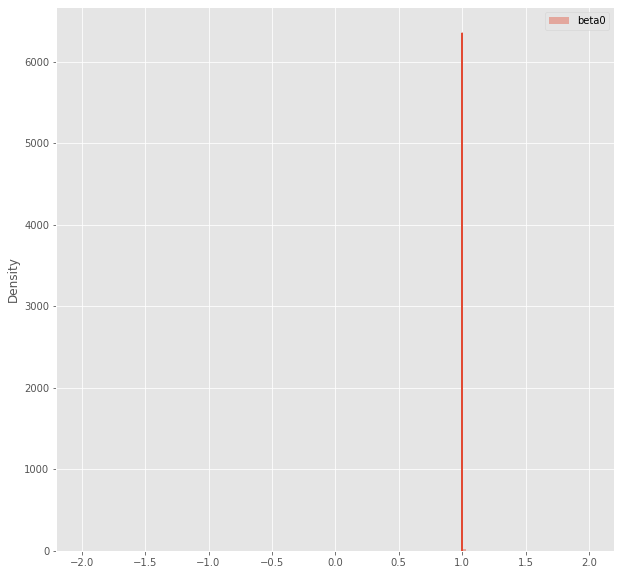

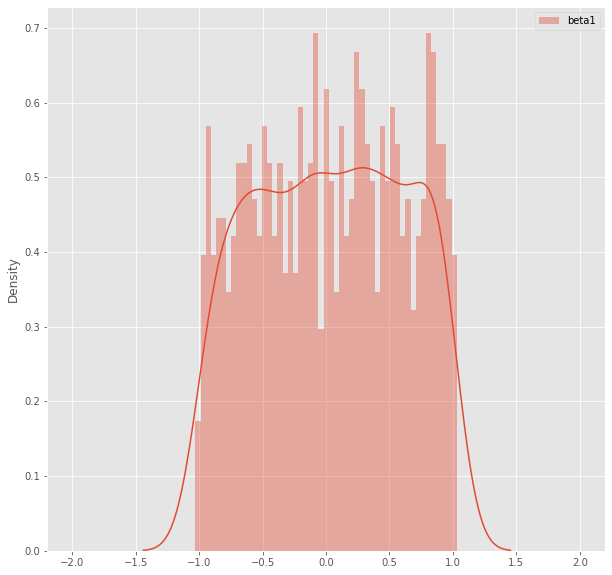

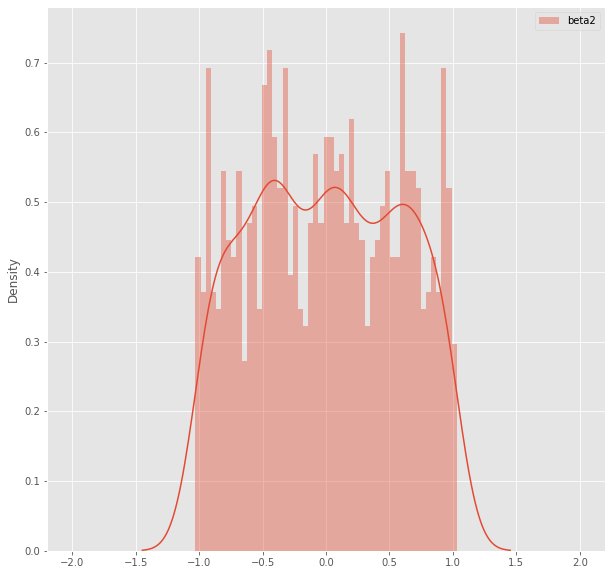

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


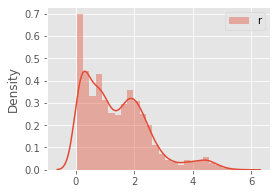

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


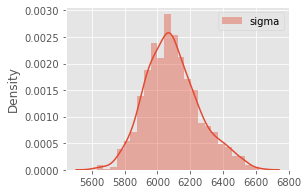

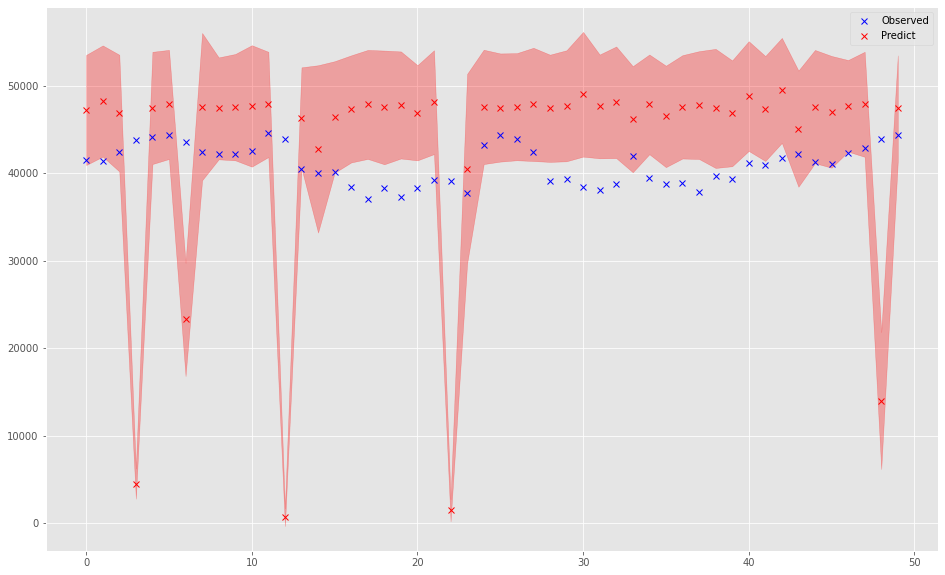

In [128]:
# get samples from model
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
# plot posterior distributions
plot_posterior(hmc_samples)
# get samples for prediction
y_pred_btc = hmc_samples["y_pred_btc"].mean(axis=0)
y_pred_std = hmc_samples["y_pred_btc"].std(axis=0)
# plot prediction
plot_predictions(y_pred_btc,y_pred_std , y_obs_btc, T, 50)

As we see, the distribution of posterior variables is far from ideal gaussian distribution that we would expect. However, the predicted values are quite close to the observed ones. We tried changing different parameters as well as distributions to better match the observed values but it resulted with no improvements of the model. We tried lognormal distribution, HalfCauchy and InverseGamma but the results were not getting better.

### Run the model with prediction based on whole dataset

In [108]:
T=1548
mcmc2, y_obs_btc2 = run_and_train_model(df_merged, 1548, 100, model_full_data_load, num_samples=1000, num_warmup=1000, N=4)


sample: 100%|██████████| 2000/2000 [10:51<00:00,  3.07it/s, 1023 steps of size 2.28e-05. acc. prob=0.78]


Total time: 11.244m


### Plot posterior distributions and predictions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

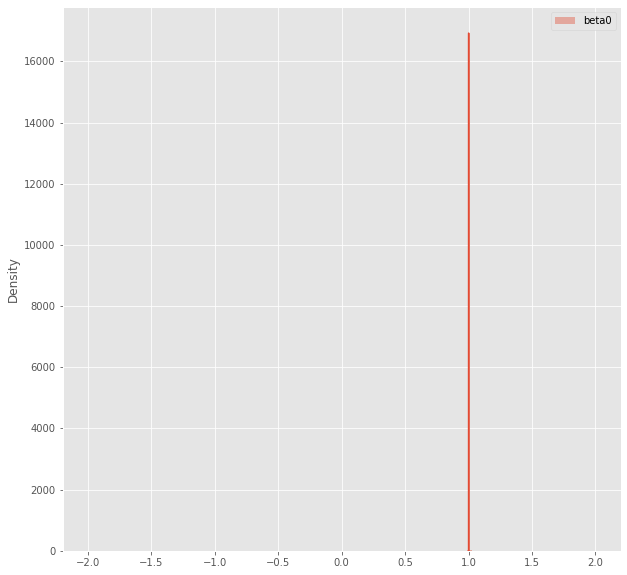

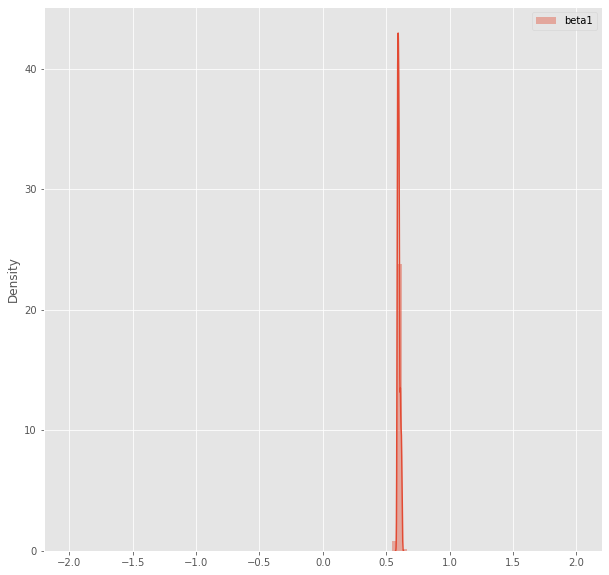

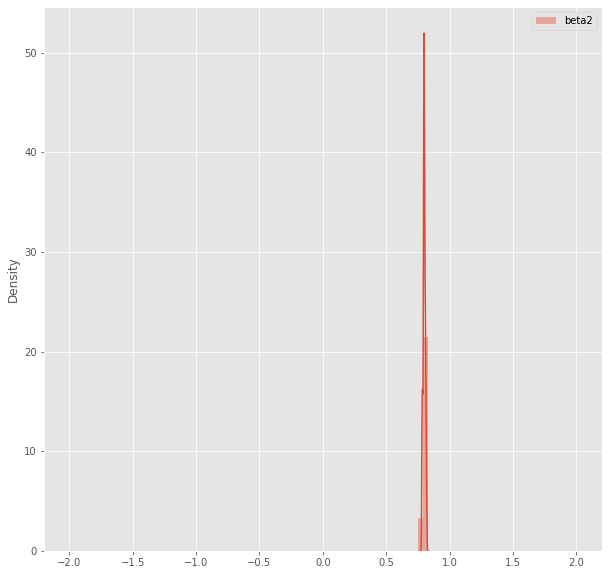

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


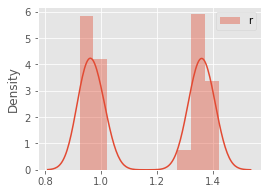

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


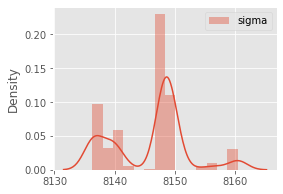

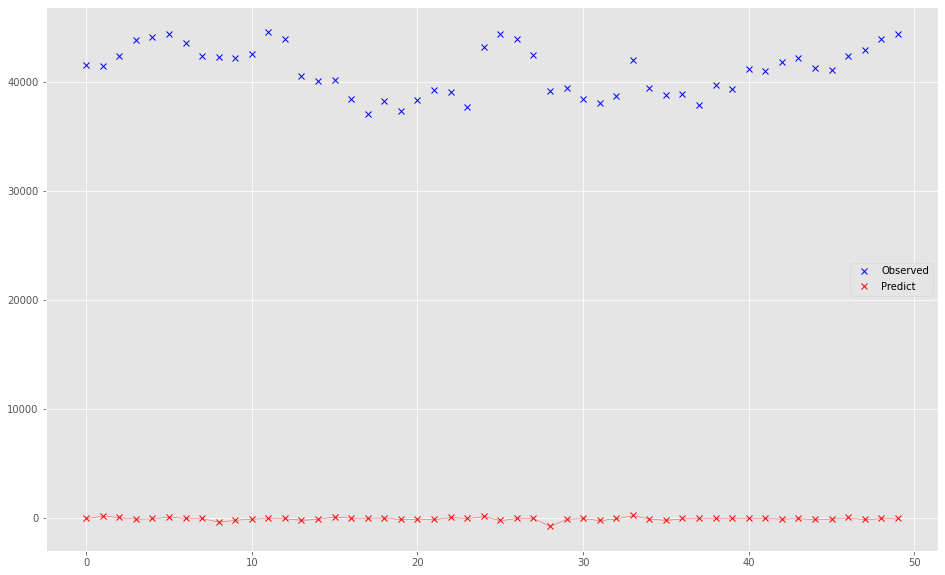

In [138]:
# get samples from model
hmc_samples2 = {k: v for k, v in mcmc2.get_samples().items()}
# plot posterior distributions
plot_posterior(hmc_samples2)
# get samples for prediction
y_pred_btc2 = hmc_samples2["y_pred_btc"].mean(axis=0)
y_pred_std2 = hmc_samples2["y_pred_btc"].std(axis=0)
# plot prediction
plot_predictions(y_pred_btc2,y_pred_std2 , y_obs_btc2, T, 50)

We can see that the results are almost equal to zero. Despite our tremendous effort put into adjusting the parameters we did not succeed and could not model the behaviour of the bitcoin price. One of the probable cause may be the complicated, nonlinear behaviuor of the data that this model cannot imitate.

### Model with Kalman kernel
As our second approach we decided to focus on Kalman filters. Kalman filter are known to be a good choice when we have a system that is changing a lot.
 We started with checking how fully connected neural network will work on our dataset.

### Definition of neural network

In [ ]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

### Model definition

In [ ]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=4, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = pyro.distributions.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", pyro.distributions.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [ ]:
# prepare data
X = torch.tensor(df_merged[["Price_USD", "Adj Close_LTC", "Adj Close_XRP"]].values).float()
y = torch.tensor(df_merged["Adj Close_BTC"].values).float()

Inference with SVI model

In [ ]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


[0] ELBO: 55205253087308.4
[500] ELBO: 55121476059292.4
[1000] ELBO: 55044930011494.9
[1500] ELBO: 54969503842984.5
[2000] ELBO: 54890202137706.2
[2500] ELBO: 54811282114235.7
[3000] ELBO: 54736438954356.2
[3500] ELBO: 54660081650855.7
[4000] ELBO: 54585762779194.4
[4500] ELBO: 54508692444272.1
[5000] ELBO: 54431496280363.4
[5500] ELBO: 54354916679257.4
[6000] ELBO: 54279394042867.4
[6500] ELBO: 54203619748372.9
[7000] ELBO: 54126075457756.8
[7500] ELBO: 54051639146456.6
[8000] ELBO: 53975944544103.7
[8500] ELBO: 53901768279899.9
[9000] ELBO: 53826308558823.5
[9500] ELBO: 53750517487869.1


Getting predictions

In [ ]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X[100:])

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


In [ ]:
ypred = samples["obs"].mean(axis=0).detach().numpy()

torch.Size([1000, 1498])
torch.Size([1000, 1498])


### Plotting results

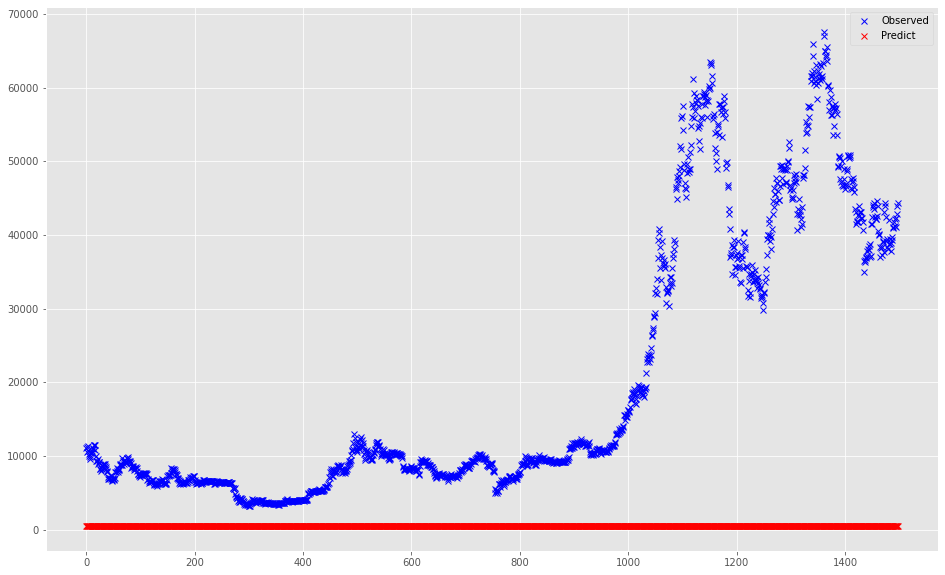

In [ ]:
plt.plot(y[100:], "bx")
plt.plot(ypred,"rx")
plt.legend(["Observed", "Predict"])
plt.show()

As we see, this model cannot adjust to our data. Probably the process is to complicated and we should use deeper network, with more layers, to better imitate the behaviour of data.

### Next we will check basic implementation of Kalman filter that pyro package offers

### Imports

In [156]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

Prepare the data, our Kalman kernel needs input type of tensor

In [157]:
X = torch.tensor(df_merged[["Adj Close_BTC","Price_USD", "Adj Close_LTC", "Adj Close_XRP"]].values).float()
y = torch.tensor(df_merged["Adj Close_BTC"].values).float()

Initial data

In [158]:
dt = 1e-2
num_frames = 1000
dim = 4

# Continuous model
ncv = NcvContinuous(dim, 2.0)

Simple model that uses Kalman kernel

In [163]:
def model(X, y=None):
    # a HalfNormal can be used here as well
    R = pyro.sample('pv_cov', dist.HalfCauchy(2e-6)) * torch.eye(4)
    Q = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(2)
    # observe the measurements
    pyro.sample('track_{}'.format(i), EKFDistribution(X[0], R, ncv,
                                                      Q, time_steps=num_frames),
                obs=y)

guide = AutoDelta(model)  # MAP estimation

Inference

In [161]:
n_steps = 1000
optim = pyro.optim.Adam({'lr': 2e-2})
svi = SVI(model, guide, optim, loss=Trace_ELBO(retain_graph=True))

pyro.set_rng_seed(0)
pyro.clear_param_store()

for i in range(n_steps):
    loss = svi.step(X[-1000: ], X[-1000:, :2])
    if not i % 100:
        print('loss: ', loss)

loss:  1798015334.538807
loss:  1797768042.5953808
loss:  1760933748.9238744
loss:  400658696.71816397
loss:  112387457.45590019
loss:  61220092.675640106
loss:  40551623.931022644
loss:  29514425.852733612
loss:  22719205.307346344
loss:  18156996.49816513


We can see that the loss value is very big and does not change much in time, that would indicate that the model does not learn. We tried different parameters values for the prior but the learing lass was still guite high.

Even though, let's try and see how the predictions look like:

In [164]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X=X[-1000:,])

NotImplementedError: ignored

The resulting error would indicate that the prediction feature was not yet implemented into package.
So let's see how the inference went.

In [ ]:
# first let's look how many inference steps have been made and select the last one to compare
print(samples.keys())

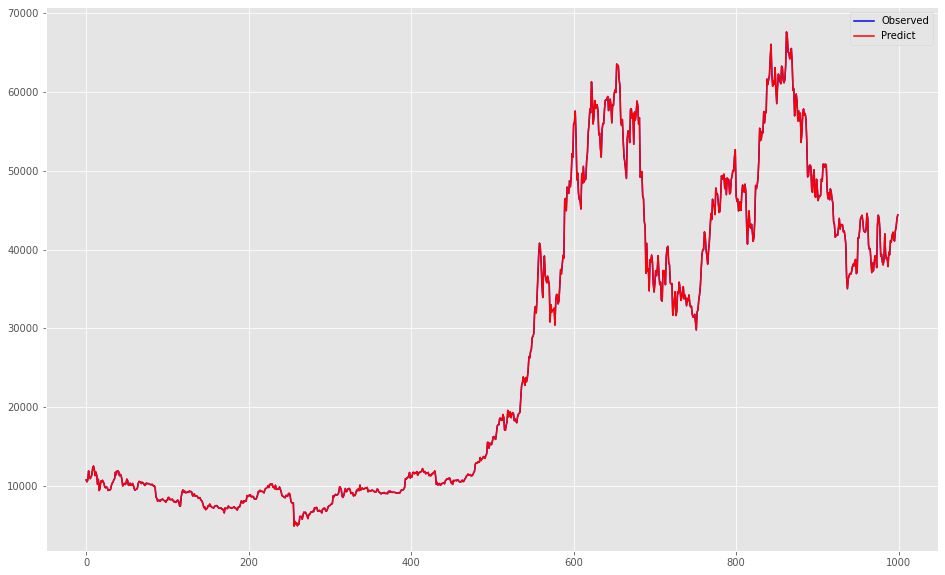

In [177]:
plt.plot(y[-1000:], "b")
plt.plot(samples["track_1958"][-1][:, 0],"r")
plt.legend(["Observed", "Predict"])
plt.show()

As we see the infered values are almost the same as observed ones.

## Kalman filters package
During our research we found a dedicated package for Kalman filters. We decided to give it a go. Let's see how good it is!

First we install the package

In [179]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Select the data we want the filter out

In [180]:
X=df_merged[["Adj Close_BTC", "Price_USD", "Adj Close_LTC", "Adj Close_XRP"]].values

Let's have a look at shape of the data

In [181]:
X.shape

(1598, 4)

Let's create our filter

In [182]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from numpy import eye, array, asarray
import numpy as np

T=X.shape[0]
dt = 13.
rk = KalmanFilter(dim_x=4, dim_z=1)

# make an imperfect starting guess
rk.x = X[0,:]

rk.F = eye(4) + array([[0, 0, 1, 0],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]]) * dt

range_std = 0.3 # meters
rk.H=np.array([[1., 1., 0., 0.]])
rk.R = np.diag([range_std**2])
rk.Q = Q_discrete_white_noise(4, dt=dt, var=0.1)
rk.P *= 50

xs, track = [], []
for i in range(T):
    z = X[i,0] # BTC price
    track.append(X[i,:])    
    rk.update(array([z]))
    xs.append(rk.x)
    rk.predict()

xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)

Plot the inference for whole dataset

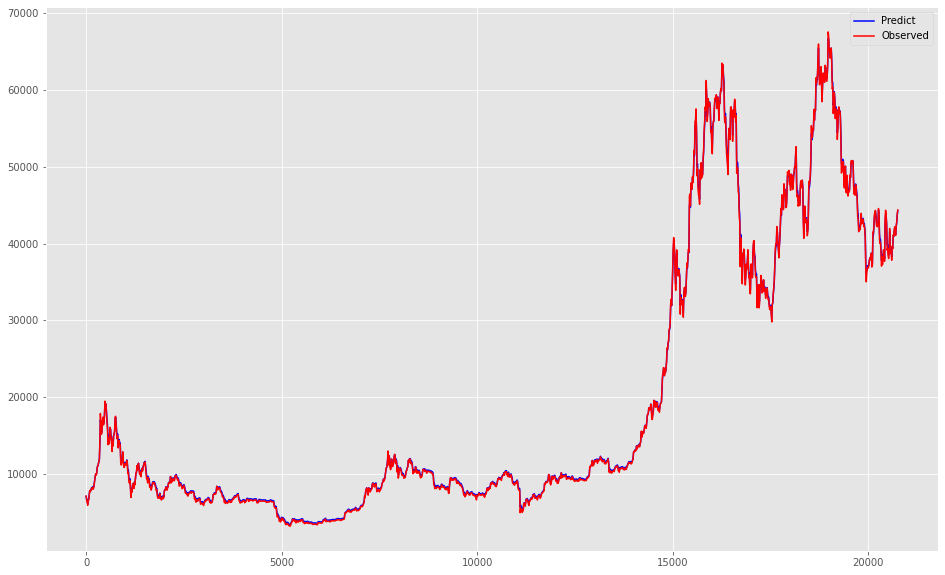

In [183]:
plt.plot(time, xs[:,0], "b")
plt.plot(time, X[:T, 0] ,"r")
plt.legend([ "Predict", "Observed"])
plt.show()

We see that the predictions made by the filter are very accurate, let's have a closer look how accurate they are:

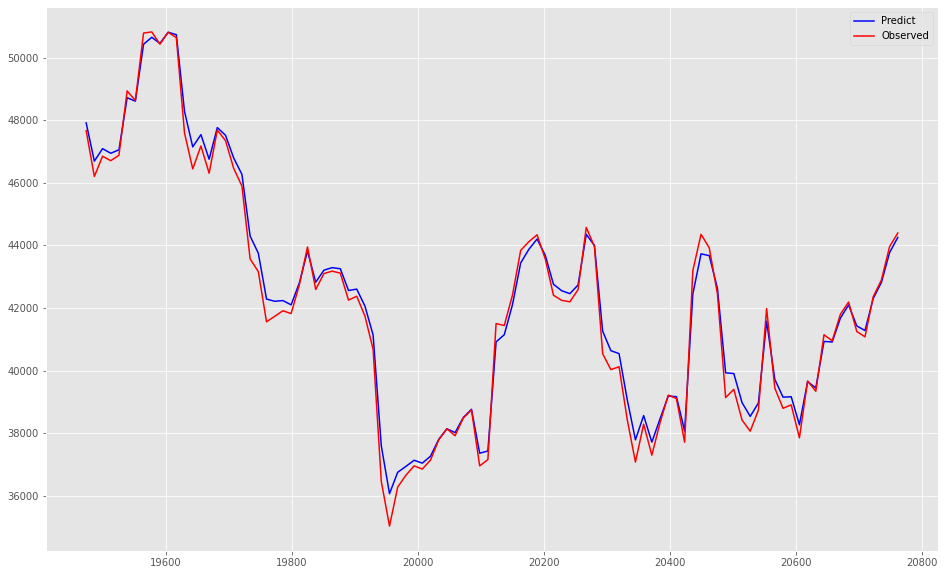

In [184]:
plt.plot(time[-100:], xs[-100:, 0], "b")
plt.plot(time[-100:], X[-100:, 0] ,"r")
plt.legend([ "Predict", "Observed"])
plt.show()

We see that the predicted values are almost the same as the original one. We managed to catch all of the variations that are in given time. The results are surprisingly good. Unfortunatelly, we cannot predict more than one step using only this filter. We tried to use it in LDS models but it raised no success. 